# Decision Trees for Classification

- In this workshop, we will learn how to conduct the [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) task of [classification](https://en.wikipedia.org/wiki/Statistical_classification) (as opposed to [regression](https://en.wikipedia.org/wiki/Regression_analysis)) using a [decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning) model and how to tune the model using [cross-validation (CV)](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). If you want to look at an in depth discussion of these concepts, take a look at this great [book](https://web.stanford.edu/~hastie/ElemStatLearn/) by Hastie, Tibshirani and Friedman.

After this workshop, you should know how to

- Model data using a decision tree
- Tune the decision tree to generalize to unseen data using cross-validation

We will use the famous [iris](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/iris.html) dataset gathered by Edgar Anderson to illustrate this process. The iris dataset is famous as it was [used](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-1809.1936.tb02137.x) by famous statistician R.A. Fisher to illustrate classification of iris species using [Linear Discriminant Analysis (LDA)](https://en.wikipedia.org/wiki/Linear_discriminant_analysis). 

In [3]:
# Load Packages
from sklearn.datasets import load_iris               # Function to load iris data
from sklearn.tree import DecisionTreeClassifier      # Build decision tree
from sklearn.tree.export import export_text          # print text tree
from sklearn import tree                             # to plot tree
from sklearn.model_selection import train_test_split # Split data into train and test

import matplotlib.pyplot as plt                      # For plotting data
import matplotlib.patches as mpatches                # For building handles for legends

import numpy as np                                   # General numeric library

# Import Data
iris = load_iris()   # Load Iris data
X = iris['data']     # Extract variables
y = iris['target']   # Extract response
desc = iris['DESCR'] # Extract description of data

print(desc)


.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

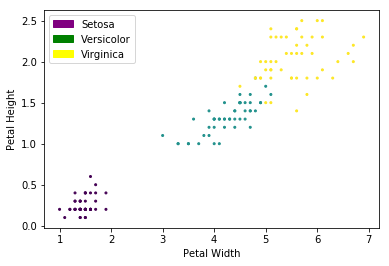

In [4]:
# Subset Data for two
X_s = X[:,2:4]

# Extract arrays of each variable
sepal_length = X[:,0:1].reshape((150,))
sepal_width = X[:,1:2].reshape((150,))
petal_width = X[:,2:3].reshape((150,))
petal_length = X[:,3:4].reshape((150,))


# Let's look at only two variables, petal width and petal length
fig, ax = plt.subplots()
scatter = ax.scatter(petal_width, petal_length, c=y, s=4)
plt.xlabel("Petal Width")
plt.ylabel("Petal Height")
setosa = mpatches.Patch(color='purple', label='Setosa')
versicolor = mpatches.Patch(color='green', label='Versicolor')
virginica = mpatches.Patch(color='yellow', label='Virginica')
plt.legend(handles=[setosa, versicolor, virginica])
plt.show()

Let's build a simple decision tree classifier with a maximum depth of 2 to predict iris species

Dendrogram for Decision Tree


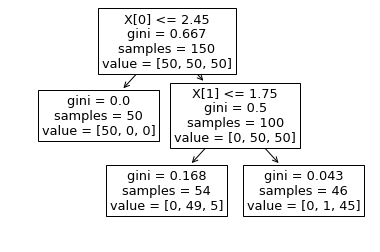

In [5]:
# Build Classifier
clf = tree.DecisionTreeClassifier(random_state = 42, max_depth=2)
clf = clf.fit(X_s, y)
tree.plot_tree(clf)
print("Dendrogram for Decision Tree")

In [4]:
# Let's plot the data with these decision boundaries
plt.scatter(petal_width, petal_length, c=y, s=4)
plt.legend(handles=[setosa, versicolor, virginica])
plt.axvline(x=2.45)
plt.axhline(y=1.75)


A quick note on how optimal decision boundaries are being calculated:

For classification, one metric to evaluate different splits is mean decrease in [gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity). It effectively estimates how expected classification accuracy would change with a given split.

For the regression case, we can simply use [reduction in mean squared error](https://en.wikipedia.org/wiki/Decision_tree_learning#Variance_reduction) as a metric for building trees. 

Let's evaluate performance of this model on this dataset. First, let's 
predict some new data points with this model:

In [5]:
# Let's predict a few query points using the model
p1 = clf.predict([[1, 1]])
p2 = clf.predict([[3, 1]])
p3 = clf.predict([[4, 2]])

print(f'Point (1, 1) is predicted to be {iris["target_names"][int(p1)]}',
      f'Point (3, 1) is predicted to be {iris["target_names"][int(p2)]}',
      f'Point (4, 2) is predicted to be {iris["target_names"][int(p3)]}', 
      sep = '\n')


Point (1, 1) is predicted to be setosa
Point (3, 1) is predicted to be versicolor
Point (4, 2) is predicted to be virginica


In [6]:
# Calculate the accuracy of the model on the data
sum(clf.predict(X_s) == y) / len(y)

0.95999999999999996

Ok. This simple model seems to fit fairly well. However, we only allowed a maximum of two splits in our decision tree. What happens if we allow more?

In [7]:
# Build Classifier
clf = tree.DecisionTreeClassifier(random_state = 42, max_depth=20)
clf = clf.fit(X_s, y)
tree.plot_tree(clf)
sum(clf.predict(X_s) == y) / len(y)

AttributeError: module 'sklearn.tree' has no attribute 'plot_tree'

Ok. This simple model seems to fit very well. However, a question one might ask is
what will be the classification accuracy on an unseen (new) dataset? For example, if another researcher came to you with a different dataset, how well will your model perform on their data?

Note that some of the terminal nodes have few samples. We might expect predictions on these nodes to not estimate probability of a given class with very much accuracy. This illustrates the problem of overfitting.

To estimate the accuracy on unseen data, we use a technique
called **cross-validation**. We simply repeat the process of randomly splitting our dataset into a training set to train the model on and test set to evaluate the model on and average a performance metric (accuracy in this setting) across replications. First let's look at one iteration of this process. Consider the following code and the image generated.

In [8]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, 
                                                        test_size=0.4, random_state = 42)
# Extract just the two variables we're interested in
x_train_s = x_train[:, 2:4]
x_test_s = x_test[:, 2:4]
clf = tree.DecisionTreeClassifier(random_state = 7, max_depth=2)
clf = clf.fit(x_train_s, y_train)

# Plot the decision tree
tree.plot_tree(clf)

# Plot the training set and testing set with these decision boundaries
pred_train = clf.predict(x_test_s)
pred_train
x_train_s[:,1]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(x_train_s[:,0], x_train_s[:,1], c=y_train, s=4)
ax1.set_title("Training Set")
ax1.axhline(y=0.8)
ax1.axhline(y=1.75)


ax2.scatter(x_test_s[:,0], x_test_s[:,1], c=pred_train, s=4)
ax2.set_title("Testing Set")
ax2.axhline(y=0.8)
ax2.axhline(y=1.75)

plt.show()

AttributeError: module 'sklearn.tree' has no attribute 'plot_tree'

Now, we repeat this process 500 times to estimate the mean predictive performance of a decision tree with a max_depth equal to 20.

In [ ]:
reps = 500
acc = []
for i in range(reps):
    x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, 
                                                        test_size=0.4)
    x_train_s = x_train[:, 2:4]
    x_test_s = x_test[:, 2:4]
    clf = tree.DecisionTreeClassifier(random_state = 42, max_depth=20)
    clf = clf.fit(x_train_s, y_train)
    acc.append(sum(clf.predict(x_test_s) == y_test) / len(y_test))

np.mean(acc)


Note that there are other (better ways) to conduct CV, and `sklearn` has a a number of modules for conducting this task (e.g. `sklearn.model_selection.cross_validate`. For now, we will leave exploring these other methods up to you. 

Now, notice how much lower performance the cross-validation error is to the model fit with the entire dataset. This suggests the model fit on the entire dataset is overfitting the data, as it doesn't match the performance we expect to see on a new dataset.

Now, let's use cross-validation to tune the depth of our tree by estimating cross-validation accuracy across a range of depths and choosing the depth whose estimated cross-validation accuracy is largest.

In [ ]:
reps = 500
depths = [x+1 for x in range(20)]
acc = []
for j in depths:
    accd = []
    for i in range(reps):
        x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, 
                                                            test_size=0.4)
        x_train_s = x_train[:, 2:4]
        x_test_s = x_test[:, 2:4]
        clf = tree.DecisionTreeClassifier(random_state = 42, max_depth=j)
        clf = clf.fit(x_train_s, y_train)
        accd.append(sum(clf.predict(x_test_s) == y_test) / len(y_test))
    acc.append(accd)

errs = np.apply_along_axis(np.mean, 1, acc)

errs = np.asarray(errs)
depths = np.asarray(depths)

plt.scatter(depths, errs)


In [ ]:
er = list(errs)

print(f'Optimal max tree-depth: {depths[er.index(max(er))]}',
      f'Optimal Average Cross validated accuracy: {max(er)}',
      sep = "\n")

It looks like a depth of {{depths[er.index(max(er))]}} is optimal for our model to generalize to unseen data and has an average cross-validated accuracy of about {{round(100* max(er), 2)}}%. Let's now fit the full model.

A quick note about the above markdown chunk: It evaluates python within the markdown chunk. But this is a feature [not yet](https://github.com/jupyter/notebook/issues/1915) built into jupyter, but can be enabled by installing the [jupyter_contrib_nbextensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions) package and enabling the appropriate [extension](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions.html) (python-markdown). You can do this with the following steps:

1. `pip install jupyter_contrib_nbextensions`
2. `jupyter contrib nbextension install --user`
3. `jupyter nbextension enable python-markdown/main`

or replacing step 1 with:
`conda install -c conda-forge jupyter_contrib_nbextensions`

In [ ]:
# Build Classifier
clf = tree.DecisionTreeClassifier(random_state = 42, max_depth=depths[er.index(max(er))])
clf = clf.fit(X_s, y)
tree.plot_tree(clf)
sum(clf.predict(X_s) == y) / len(y)

Notice we get a higher accuracy on our dataset. However, this overestimates the accuracy on unseen data that is estimated via cross-validation.

Now, we only used two of the four variables in our dataset to build our model. Let's build and tune the model using the full dataset.

In [ ]:
reps = 500 #CV Reps
depths = [x+1 for x in range(20)] # Range of tuning parameter (depth)
acc = []
for j in depths:
    accd = []
    for i in range(reps):
        x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, 
                                                            test_size=0.4)
        clf = tree.DecisionTreeClassifier(random_state = 42, max_depth=j)
        clf = clf.fit(x_train, y_train)
        accd.append(sum(clf.predict(x_test) == y_test) / len(y_test))
    acc.append(accd)

errs = np.apply_along_axis(np.mean, 1, acc)

errs = np.asarray(errs)
depths = np.asarray(depths)

plt.scatter(depths, errs)

In [ ]:
er = list(errs)

print(f'Optimal tree depth: {depths[er.index(max(er))]}',
      f'Optimal Average Cross validated accuracy: {max(er)}',
      sep = "\n")

It seems the extra variables gave us very little extra information to improve our classifier.

# Exercise

- Use the code above to build and tune a classifier for the wine dataset (see code below)
- Use the code above to build and tune a regressor for the boston dataset (hint: you may want to use the [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) class object from scikit-learn )


In [ ]:
from sklearn.datasets import load_wine

# Load Data
wine = load_wine()
X = wine['data']
y = wine['target']
desc = wine['DESCR']

print(desc)

In [ ]:
from sklearn.datasets import load_boston

# Load Data
boston = load_boston()

